## NVIDIA Price Prediction Project

In [45]:
import warnings as wg
wg.filterwarnings('ignore')

In [46]:
# Let's import libraries
import re
import requests
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import itertools
import warnings
import seaborn as sns
import lightgbm as lgb
from matplotlib import pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [48]:
# Let's create time series model
df = pd.read_csv('NVDA Historical Data.csv')
df = df[['Date','Price']]
df['Date'] = pd.to_datetime(df['Date'])

In [49]:
# Let's sorted dataset by date column
df_sorted = df.sort_values(by='Date')
df_sorted.set_index('Date', inplace = True)

In [50]:
df_sorted.index

DatetimeIndex(['2023-01-03', '2023-01-04', '2023-01-05', '2023-01-06',
               '2023-01-09', '2023-01-10', '2023-01-11', '2023-01-12',
               '2023-01-13', '2023-01-17',
               ...
               '2024-06-05', '2024-06-06', '2024-06-07', '2024-06-10',
               '2024-06-11', '2024-06-12', '2024-06-13', '2024-06-14',
               '2024-06-17', '2024-06-18'],
              dtype='datetime64[ns]', name='Date', length=367, freq=None)

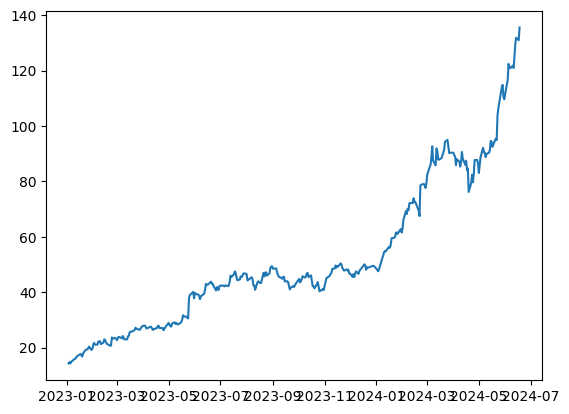

In [51]:
# Let's look at in plot
import matplotlib.pyplot as plt
plt.plot(df_sorted)
plt.show()

In [52]:
# Let's divide train and test dataset
train = df_sorted[:int(len(df_sorted)*0.9)]
test = df_sorted[int(len(df_sorted)*0.9):]

### Single Exponential Smoothing

alpha: 0.01 mae: 42.7321
alpha: 0.11 mae: 20.4614
alpha: 0.21 mae: 22.1548
alpha: 0.31 mae: 22.8993
alpha: 0.41 mae: 23.0998
alpha: 0.51 mae: 23.0448
alpha: 0.61 mae: 22.8813
alpha: 0.71 mae: 22.679
alpha: 0.81 mae: 22.461
alpha: 0.91 mae: 22.2229
best_alpha: 0.11 best_mae: 20.4614


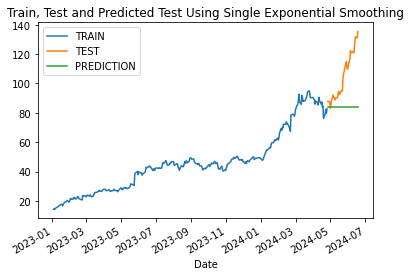

In [ ]:
# Let's use SES (Single Exponential Smoothing)

### Let's create function for find the best parameters ###
def ses_optimizer(train, test, alphas, step=24):
    best_alpha, best_mae = None, float("inf")
    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(test[:step], y_pred)
        if mae < best_mae:
            best_alpha, best_mae = alpha, mae
        print("alpha:", round(alpha, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_mae

### Let's get the best parameters ###
alphas = np.arange(0.01, 1, 0.10)
best_alpha, best_mae = ses_optimizer(train, test, alphas, step=len(test))

### Let's use ses method and predict test values ###
ses_model = SimpleExpSmoothing(train).fit(smoothing_level=best_alpha)
step = len(test)
y_pred = ses_model.forecast(step)
y_pred.index = test.index

### Let's create plot function for visualize plots ###
def plot_prediction(y_pred, label):
    train["Price"].plot(legend=True, label="TRAIN")
    test["Price"].plot(legend=True, label="TEST")
    y_pred.plot(legend=True, label="PREDICTION")
    plt.title("Train, Test and Predicted Test Using "+label)
    plt.show()

plot_prediction(y_pred, "Single Exponential Smoothing")

In [ ]:
test_series = test.reset_index(drop = True)
y_pred_series = y_pred.reset_index(drop = True)

concatenated_series = pd.concat([test_series, y_pred_series], axis=1)

concatenated_series.columns = ['Actual Price','Predictio Price']
concatenated_series['Difference'] = concatenated_series['Actual Price'] - concatenated_series['Predictio Price']

concatenated_series.head()

,Actual Price,Predictio Price,Difference
0,87.73,84.209086,3.520914
1,87.76,84.209086,3.550914
2,86.40,84.209086,2.190914
3,83.04,84.209086,-1.169086
4,85.82,84.209086,1.610914


### Double Exponential Smoothing

alpha: 0.01 beta: 0.01 mae: 22.2305
alpha: 0.01 beta: 0.11 mae: 11.8247
alpha: 0.01 beta: 0.21 mae: 14.6207
alpha: 0.01 beta: 0.31 mae: 14.6566
alpha: 0.01 beta: 0.41 mae: 16.9559
alpha: 0.01 beta: 0.51 mae: 24.0001
alpha: 0.01 beta: 0.61 mae: 34.799
alpha: 0.01 beta: 0.71 mae: 41.5511
alpha: 0.01 beta: 0.81 mae: 45.7915
alpha: 0.01 beta: 0.91 mae: 51.5269
alpha: 0.11 beta: 0.01 mae: 13.1666
alpha: 0.11 beta: 0.11 mae: 34.4759
alpha: 0.11 beta: 0.21 mae: 41.885
alpha: 0.11 beta: 0.31 mae: 39.4573
alpha: 0.11 beta: 0.41 mae: 36.7546
alpha: 0.11 beta: 0.51 mae: 37.837
alpha: 0.11 beta: 0.61 mae: 40.9509
alpha: 0.11 beta: 0.71 mae: 43.0763
alpha: 0.11 beta: 0.81 mae: 43.8975
alpha: 0.11 beta: 0.91 mae: 42.7983
alpha: 0.21 beta: 0.01 mae: 16.7965
alpha: 0.21 beta: 0.11 mae: 35.3861
alpha: 0.21 beta: 0.21 mae: 38.0251
alpha: 0.21 beta: 0.31 mae: 38.5767
alpha: 0.21 beta: 0.41 mae: 39.571
alpha: 0.21 beta: 0.51 mae: 40.1468
alpha: 0.21 beta: 0.61 mae: 40.8372
alpha: 0.21 beta: 0.71 mae: 41.2

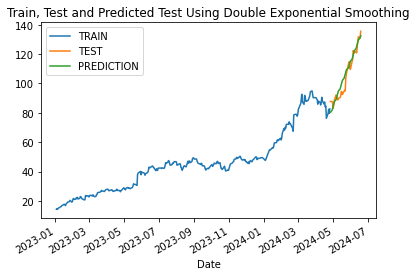

In [ ]:
# Let's use SES (Single Exponential Smoothing)

### Let's create function for find the best parameters ###
def des_optimizer(train, test, alphas, betas, step=48):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=alpha, smoothing_slope=beta)
            y_pred = des_model.forecast(step)
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
            print("alpha:", round(alpha, 2), "beta:", round(beta, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_beta, best_mae

### Let's get the best parameters ###
alphas = np.arange(0.01, 1, 0.10)
betas = np.arange(0.01, 1, 0.10)

### Let's use ses method and predict test values ###
best_alpha, best_beta, best_mae = des_optimizer(train, test, alphas, betas, step=len(test))
des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=best_alpha,
                                                         smoothing_slope=best_beta)
step = len(test)
y_pred = des_model.forecast(step)
y_pred.index = test.index

### Let's create plot function for visualize plots ###
plot_prediction(y_pred, "Double Exponential Smoothing")

### Triple Exponential Smoothing (Holt-Winters)

In [ ]:
### Let's create plot function for visualize plots ###
def plot_prediction(y_pred, label):
    train["Price"].plot(legend=True, label="TRAIN")
    test["Price"].plot(legend=True, label="TEST")
    y_pred.plot(legend=True, label="PREDICTION")
    plt.title("Train, Test and Predicted Test Using "+label)
    plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-p

[0.1, 0.1, 0.1, 31.25]
[0.1, 0.1, 0.3, 29.94]
[0.1, 0.1, 0.5, 28.59]
[0.1, 0.1, 0.7, 27.34]
[0.1, 0.1, 0.9, 26.49]
[0.1, 0.3, 0.1, 39.77]
[0.1, 0.3, 0.3, 37.0]
[0.1, 0.3, 0.5, 34.75]
[0.1, 0.3, 0.7, 33.46]
[0.1, 0.3, 0.9, 34.23]
[0.1, 0.5, 0.1, 36.15]
[0.1, 0.5, 0.3, 35.56]
[0.1, 0.5, 0.5, 34.07]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-p

[0.1, 0.5, 0.7, 33.18]
[0.1, 0.5, 0.9, 36.29]
[0.1, 0.7, 0.1, 41.3]
[0.1, 0.7, 0.3, 37.46]
[0.1, 0.7, 0.5, 27.43]
[0.1, 0.7, 0.7, 5.39]
[0.1, 0.7, 0.9, 4.77]
[0.1, 0.9, 0.1, 41.58]
[0.1, 0.9, 0.3, 26.53]
[0.1, 0.9, 0.5, 11.82]
[0.1, 0.9, 0.7, 24.19]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-p

[0.1, 0.9, 0.9, 10.19]
[0.3, 0.1, 0.1, 33.6]
[0.3, 0.1, 0.3, 32.97]
[0.3, 0.1, 0.5, 31.86]
[0.3, 0.1, 0.7, 30.13]
[0.3, 0.1, 0.9, 27.82]
[0.3, 0.3, 0.1, 37.53]
[0.3, 0.3, 0.3, 40.06]
[0.3, 0.3, 0.5, 42.72]
[0.3, 0.3, 0.7, 44.16]
[0.3, 0.3, 0.9, 38.79]
[0.3, 0.5, 0.1, 35.56]
[0.3, 0.5, 0.3, 42.3]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-p

[0.3, 0.5, 0.5, 46.35]
[0.3, 0.5, 0.7, 32.66]
[0.3, 0.5, 0.9, 24.26]
[0.3, 0.7, 0.1, 22.92]
[0.3, 0.7, 0.3, 29.91]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-p

[0.3, 0.7, 0.5, 23.36]
[0.3, 0.7, 0.7, 13.8]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has b

[0.3, 0.7, 0.9, 287159925211.63]
[0.3, 0.9, 0.1, 8.38]
[0.3, 0.9, 0.3, 11.94]
[0.3, 0.9, 0.5, 5.9]
[0.3, 0.9, 0.7, 12.26]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has b

[0.3, 0.9, 0.9, 36545252467418.07]
[0.5, 0.1, 0.1, 31.72]
[0.5, 0.1, 0.3, 32.11]
[0.5, 0.1, 0.5, 32.29]
[0.5, 0.1, 0.7, 32.38]
[0.5, 0.1, 0.9, 30.74]
[0.5, 0.3, 0.1, 29.26]
[0.5, 0.3, 0.3, 31.91]
[0.5, 0.3, 0.5, 31.89]
[0.5, 0.3, 0.7, 25.98]
[0.5, 0.3, 0.9, 18.82]
[0.5, 0.5, 0.1, 17.27]
[0.5, 0.5, 0.3, 20.75]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-p

[0.5, 0.5, 0.5, 20.65]
[0.5, 0.5, 0.7, 6.9]
[0.5, 0.5, 0.9, 8.57]
[0.5, 0.7, 0.1, 6.54]
[0.5, 0.7, 0.3, 17.94]
[0.5, 0.7, 0.5, 20.13]
[0.5, 0.7, 0.7, 15.55]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has b

[0.5, 0.7, 0.9, 9.19]
[0.5, 0.9, 0.1, 3.98]
[0.5, 0.9, 0.3, 33.13]
[0.5, 0.9, 0.5, 37.37]
[0.5, 0.9, 0.7, 9.23]
[0.5, 0.9, 0.9, 970.24]
[0.7, 0.1, 0.1, 29.36]
[0.7, 0.1, 0.3, 29.08]
[0.7, 0.1, 0.5, 32.07]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-p

[0.7, 0.1, 0.7, 29.93]
[0.7, 0.1, 0.9, 27.05]
[0.7, 0.3, 0.1, 22.84]
[0.7, 0.3, 0.3, 23.27]
[0.7, 0.3, 0.5, 33.61]
[0.7, 0.3, 0.7, 29.18]
[0.7, 0.3, 0.9, 20.91]
[0.7, 0.5, 0.1, 10.89]
[0.7, 0.5, 0.3, 13.98]
[0.7, 0.5, 0.5, 44.89]
[0.7, 0.5, 0.7, 20.88]
[0.7, 0.5, 0.9, 9.29]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-p

[0.7, 0.7, 0.1, 5.31]
[0.7, 0.7, 0.3, 4.31]
[0.7, 0.7, 0.5, 13.52]
[0.7, 0.7, 0.7, 18.07]
[0.7, 0.7, 0.9, 7.86]
[0.7, 0.9, 0.1, 3.97]
[0.7, 0.9, 0.3, 17.69]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-p

[0.7, 0.9, 0.5, 27.43]
[0.7, 0.9, 0.7, 21.72]
[0.7, 0.9, 0.9, 105.37]
[0.9, 0.1, 0.1, 27.14]
[0.9, 0.1, 0.3, 25.9]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-p

[0.9, 0.1, 0.5, 29.05]
[0.9, 0.1, 0.7, 34.08]
[0.9, 0.1, 0.9, 27.99]
[0.9, 0.3, 0.1, 18.17]
[0.9, 0.3, 0.3, 13.44]
[0.9, 0.3, 0.5, 23.65]
[0.9, 0.3, 0.7, 27.43]
[0.9, 0.3, 0.9, 32.06]
[0.9, 0.5, 0.1, 7.38]
[0.9, 0.5, 0.3, 4.51]
[0.9, 0.5, 0.5, 5.12]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-p

[0.9, 0.5, 0.7, 6.85]
[0.9, 0.5, 0.9, 14.92]
[0.9, 0.7, 0.1, 4.36]
[0.9, 0.7, 0.3, 5.01]
[0.9, 0.7, 0.5, 20.46]
[0.9, 0.7, 0.7, 39.25]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-p

[0.9, 0.7, 0.9, 5.88]
[0.9, 0.9, 0.1, 11.01]
[0.9, 0.9, 0.3, 4.94]
[0.9, 0.9, 0.5, 11.99]
[0.9, 0.9, 0.7, 38.7]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer

[0.9, 0.9, 0.9, 935839759803.8]
best_alpha: 0.7 best_beta: 0.9 best_gamma: 0.1 best_mae: 3.9676
Please enter how many days are you want to predict?: 50


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


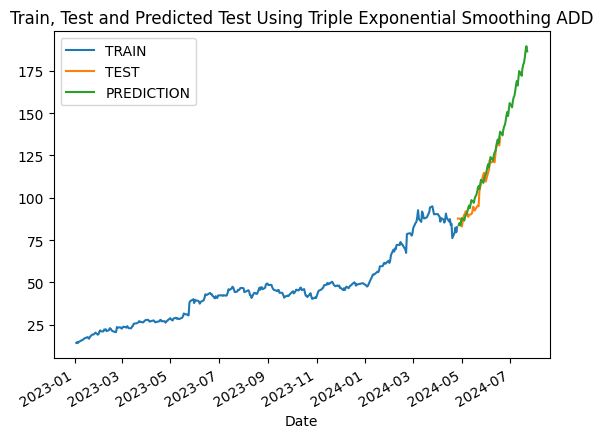

In [ ]:
# Let's use SES (Single Exponential Smoothing)

### Let's create function for find the best parameters ###
def tes_optimizer(train, test, abg, step=48):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
        print([round(comb[0], 2), round(comb[1], 2), round(comb[2], 2), round(mae, 2)])

    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae

### Let's get the best parameters ###
alphas = betas = gammas = np.arange(0.10, 1, 0.20)
abg = list(itertools.product(alphas, betas, gammas))

### Let's use ses method and predict test values ###
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, test , abg, step= len(test))
tes_model = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=12).\
            fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)
# step = len(test)
# y_pred = tes_model.forecast(step)
# y_pred.index = test.index

advance_step = int(input('Please enter how many days are you want to predict?: '))
step = len(test) + advance_step
y_pred = tes_model.forecast(steps=step)
future_dates = pd.date_range(start=test.index[0] + pd.Timedelta(days=1), periods=step, freq='D')
y_pred.index = future_dates

### Let's create plot function for visualize plots ###
plot_prediction(y_pred, "Triple Exponential Smoothing ADD")

### Let's use machine learning methods

In [53]:
# Firstly, let's define new features
def create_date_features(df, date_column):
    df['month'] = df[date_column].dt.month
    df['day_of_month'] = df[date_column].dt.day
    df['day_of_year'] = df[date_column].dt.dayofyear
    df['week_of_year'] = df[date_column].dt.isocalendar().week
    df['day_of_week'] = df[date_column].dt.dayofweek
    df['year'] = df[date_column].dt.year
    df["is_wknd"] = df[date_column].dt.weekday // 4
    df['is_month_start'] =df[date_column].dt.is_month_start.astype(int)
    df['is_month_end'] = df[date_column].dt.is_month_end.astype(int)
    df['quarter'] = df[date_column].dt.quarter
    df['is_quarter_start'] = df[date_column].dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df[date_column].dt.is_quarter_end.astype(int)
    df['is_year_start'] = df[date_column].dt.is_year_start.astype(int)
    df['is_year_end'] = df[date_column].dt.is_year_end.astype(int)
    return df

In [54]:
df_sorted = df_sorted.reset_index()
df = create_date_features(df_sorted, "Date")

### Lag/Shifted Features

In [55]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe['Price'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

df = lag_features(df, [1,3,5,7,15,29,30,31])

### Rolling Mean Features

In [56]:
# Function to add random noise
def random_noise(dataframe, noise_level=0.01):
    return np.random.randn(len(dataframe)) * noise_level

# Function to calculate rolling mean features
def roll_mean_features(dataframe, windows):
    for window in windows:
        column_name = f'sales_roll_mean_{window}'
        dataframe[column_name] = dataframe['Price'].shift(1).rolling(window=window, min_periods=1, win_type='triang').mean()
        dataframe[column_name] += random_noise(dataframe)
    return dataframe

df = roll_mean_features(df, [3,5,7,15,29,30,31])

### Exponentially Weighted Mean Features

In [57]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe['Price'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [1,3,5,7,15,29,30,31]

df = ewm_features(df, alphas, lags)

### One-Hot Encoding

In [58]:
df = pd.get_dummies(df, columns=['day_of_week', 'month', 'year'])
df['Price'] = np.log1p(df["Price"].values)
for i in df.select_dtypes(include = bool):
    df[i] = df[i].astype('int')

### Regression models

In [59]:
### Let's check null values
df.isnull().sum()[df.isnull().sum() >= 1]

### Let's remove null values
df.dropna(inplace = True)

In [60]:
# Let's check 1 unique values columns
a = []
for i in df.columns:
  # print(i,":",df[i].unique()[:5])
  if df[i].nunique() < 2:
    a.append(i)

In [61]:
# Let's remove this columns from dataframe
df.drop(columns = a, inplace = True)

In [62]:
from sklearn.model_selection import train_test_split
df2 = df.drop(columns=['Date'])

X = df2.drop(columns=['Price'])
y = df2['Price']

if X.isnull().sum().any():
    X = X.fillna(0)

train = df2[:int(len(df2)*0.8)]
test = df2[int(len(df2)*0.8):]

y_train = train['Price']
X_train = train.drop(columns = 'Price')

y_test = test['Price']
X_test = test.drop(columns = 'Price')

In [80]:
# Set parameters for the Random Forest
params = {
    'n_estimators': 100,
    'max_depth': 10,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'random_state': 42
}

# Initialize and train the Random Forest Regressor
rf = RandomForestRegressor(**params)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, random_state=42)

In [81]:
# Make predictions on the test set
y_test_pred = rf.predict(X_test)

# Evaluate the model
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
print(f'RMSE on test set: {rmse_test}')

RMSE on test set: 0.15411529554557069


In [82]:
# Get feature importance
importance = rf.feature_importances_
feature_names = X.columns

for name, imp in zip(feature_names, importance):
    print(f'{name}: {imp}')

day_of_month: 0.00027666681447268077
day_of_year: 0.002039866315257052
week_of_year: 0.00015501035823294756
is_wknd: 1.493941565333957e-05
is_month_start: 3.512384470194573e-06
is_month_end: 3.322343514394527e-06
quarter: 8.840458756932299e-05
is_quarter_start: 0.0
is_quarter_end: 7.179604610760935e-07
sales_lag_1: 0.019035028983795558
sales_lag_3: 0.007179930978804549
sales_lag_5: 0.011673231766131435
sales_lag_7: 0.005388042104392484
sales_lag_15: 0.00028141021054765917
sales_lag_29: 0.0006927370658443168
sales_lag_30: 0.0007446793691301805
sales_lag_31: 0.00039151797878722464
sales_roll_mean_3: 0.03539462220107083
sales_roll_mean_5: 0.026398639610146102
sales_roll_mean_7: 0.045303522538251595
sales_roll_mean_15: 0.06307335310376659
sales_roll_mean_29: 0.05569735569793462
sales_roll_mean_30: 0.0537642362413033
sales_roll_mean_31: 0.038464556795633875
sales_ewm_alpha_095_lag_1: 0.02402980794691962
sales_ewm_alpha_095_lag_3: 0.016813373527177506
sales_ewm_alpha_095_lag_5: 0.03525842677

<Axes: >

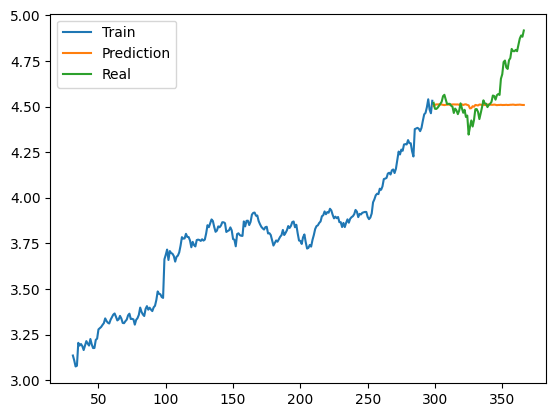

In [85]:
y_test_pred = pd.Series(y_test_pred)
y_test_pred.index = y_test.index

y_train.plot(legend = True, label = 'Train')
y_test_pred.plot(legend = True, label = 'Prediction')
y_test.plot(legend = True, label = 'Real')

### The End